In [2]:
Subsets_Chew= [['protein','fat','carbs']]

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import sort
from sklearn.feature_selection import SelectFromModel
# import seaborn as sns
import csv
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, LeaveOneGroupOut, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'xgboost'

# Chewiness (Shi Jing's order)

In [3]:
# 30 + 12 + 12 data + others
data = pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv')
m = data.shape[0]
print(f'number of samples: {m}')

data = data.replace(['YPI-com','YPI-local','FBC-com', 'FBI-local'], [79, 81, 56, 88])
data.WG_frac = pd.to_numeric(data.WG_frac)
groups = list(data.WG_frac.unique())
m_groups = len(groups)
print(f'groups: {groups}')
print(f'number of groups: {m_groups}')

# colors
#cm_subsection = np.linspace(0.1, 0.98, m_groups)
#colors = [cm.jet(x) for x in cm_subsection]
#gcolors = dict(zip(groups, colors))
# markers
chiang19 = 'o'
chiang21 = 'd'
HMMA = '^'
markers = 4*chiang19 + 4*chiang21 + 4*HMMA
gmarkers = dict(zip(groups, markers))

print(f'features: {data.columns.values}')

number of samples: 54
groups: [0, 10, 20, 30, 40, 60, 80, 100, 79, 81, 56, 88]
number of groups: 12
features: ['no' 'WG_frac' 'protein' 'target moisture' 'moisture' 'ash' 'carbs' 'fat'
 'fiber' 'Hardness' 'Chewiness' 'Group_ID' 'Unnamed: 12' 'Unnamed: 13']


features: ['protein' 'target moisture' 'moisture' 'ash' 'carbs' 'fat' 'fiber']


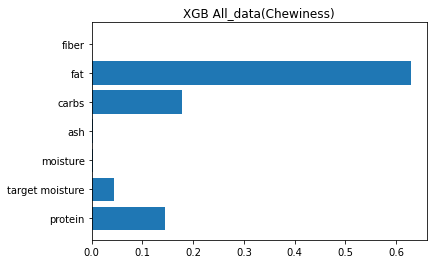

In [11]:
# default parameters
X = data.iloc[:, 2:9]
response = 'Chewiness'
y = data.loc[:, response]
print(f'features: {X.columns.values}')

xg_reg = xgb.XGBRegressor()

gkfold = GroupKFold(n_splits=m_groups).split(X, y, list(data.WG_frac))
y_predicted = [0 for i in range(m)]
y_true_groups = [[] for i in range(m_groups)]
y_predicted_groups = [[] for i in range(m_groups)]
y_predicted_2=[]
y_true_2=[]

scores_sum=0


# print(test_features)
xg_reg.fit(X, y)

scores_sum += xg_reg.feature_importances_
plt.barh(X.columns, xg_reg.feature_importances_)
plt.title('XGB All_data'+ '('+response+')')
plt.show()



features: ['protein' 'carbs' 'fat']
MAPE: 15.8%
RMSE: 7.030


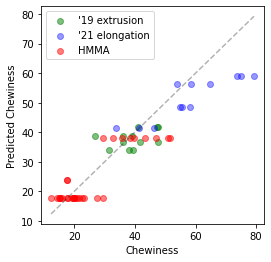

MAPE: 15.8%
RMSE: 7.030


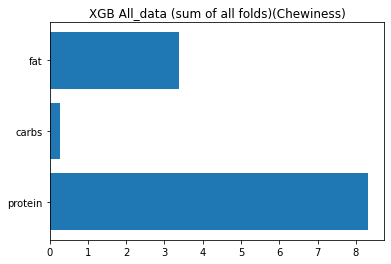

In [15]:
# default parameters
X = data.loc[:, ['protein','carbs','fat']]
response = 'Chewiness'
y = data.loc[:, response]
print(f'features: {X.columns.values}')

xg_reg = xgb.XGBRegressor()

gkfold = GroupKFold(n_splits=m_groups).split(X, y, list(data.WG_frac))
y_predicted = [0 for i in range(m)]
y_true_groups = [[] for i in range(m_groups)]
y_predicted_groups = [[] for i in range(m_groups)]
y_predicted_2=[]
y_true_2=[]

scores_sum=0

for train_idx, test_idx in gkfold:
    tr_features = X.iloc[train_idx, :]
    tr_label = y.iloc[train_idx]
    test_features = X.iloc[test_idx, :]
    test_label = y.iloc[test_idx]
   # print(test_features)
    xg_reg.fit(tr_features, tr_label)
    
    scores_sum += xg_reg.feature_importances_
  #  plt.barh(tr_features.columns, xg_reg.feature_importances_)
   # plt.title('XGB All_data'+ '('+response+')')
   # plt.show()
    
    label_predict = xg_reg.predict(test_features)
   # print(label_predict) 
    m_label_predict = len(label_predict)
    y_predicted[test_idx[0]:test_idx[0] + m_label_predict] = label_predict
    #print(y_predicted) 
    y_predicted_2.extend(label_predict)
    y_true_2.extend(test_label)
    group_idx = groups.index(data.WG_frac[test_idx[0]])
    y_predicted_groups[group_idx] = label_predict
    y_true_groups[group_idx] = y.iloc[test_idx[0]:test_idx[0] + m_label_predict]
    #print('group_idx: ', group_idx)
    
    #print(y_true_groups)
    

y_true_2=np.array(y_true_2)
y_predicted_2=np.array(y_predicted_2)

mape = np.mean(np.abs((y_true_2 - y_predicted_2)/y_true_2))*100
print(f'MAPE: {mape:.1f}%')
rmse = (mean_squared_error(y_true_2, y_predicted_2, squared=False))

print(f'RMSE: {rmse:.3f}')

plt.figure(figsize=(4,4))
ax = plt.axes()
ax.scatter(y[:12], y_predicted[:12], color='green', alpha = 0.5)
ax.scatter(y[12:24], y_predicted[12:24], color='blue', alpha = 0.4)
ax.scatter(y[24:], y_predicted[24:], color='red', alpha=0.5)
plt.legend(["'19 extrusion", "'21 elongation", "HMMA"])
ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', alpha = 0.3)
ax.set_xlabel('Chewiness')
ax.set_ylabel('Predicted Chewiness')
plt.show()

mape = np.mean(np.abs((y - y_predicted)/y))*100
print(f'MAPE: {mape:.1f}%')
rmse = np.sqrt(mean_squared_error(y, y_predicted))
print(f'RMSE: {rmse:.3f}')

plt.barh(tr_features.columns, scores_sum)
plt.title('XGB All_data (sum of all folds)'+ '('+response+')')
plt.show()

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]
        #print(data[not_exog])
        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)
        print(exog," r_squared: ",r_squared)
        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

#exogs=list(features_all)
exogs=['protein','carbs', 'fat']
sklearn_vif(exogs, data)

protein  r_squared:  0.7015663648512334
carbs  r_squared:  0.8141866746032584
fat  r_squared:  0.6013514580312934


,VIF,Tolerance
protein,3.350829,0.298434
carbs,5.381745,0.185813
fat,2.508475,0.398649


# Hardness (Shi Jing's order)

In [21]:
# 30 + 12 + 12 data + others
data = pd.read_csv('additional_30_12_12.csv')
m = data.shape[0]
print(f'number of samples: {m}')

data = data.replace(['YPI-com','YPI-local','FBC-com', 'FBI-local'], [79, 81, 56, 88])
data.WG_frac = pd.to_numeric(data.WG_frac)
groups = list(data.WG_frac.unique())
m_groups = len(groups)
print(f'groups: {groups}')
print(f'number of groups: {m_groups}')

# colors
cm_subsection = np.linspace(0.1, 0.98, m_groups)
colors = [cm.jet(x) for x in cm_subsection]
gcolors = dict(zip(groups, colors))
# markers
chiang19 = 'o'
chiang21 = 'd'
HMMA = '^'
markers = 4*chiang19 + 4*chiang21 + 4*HMMA
gmarkers = dict(zip(groups, markers))

print(f'features: {data.columns.values}')

number of samples: 54
groups: [0, 10, 20, 30, 40, 60, 80, 100, 79, 81, 56, 88]
number of groups: 12
features: ['Unnamed: 0' 'WG_frac' 'protein_pre' 'moisture' 'moisture_pre' 'ash'
 'carbs' 'fat' 'fiber' 'Hardness' 'Chewiness']


features: ['protein' 'target moisture' 'moisture' 'ash' 'carbs' 'fat' 'fiber']


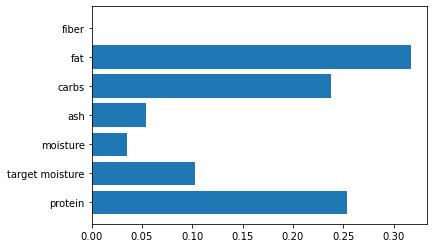

In [16]:
# default parameters
X = data.iloc[:, 2:9]
response = 'Hardness'
y = data.loc[:, response]
print(f'features: {X.columns.values}')

xg_reg = xgb.XGBRegressor()

gkfold = GroupKFold(n_splits=m_groups).split(X, y, list(data.WG_frac))
y_predicted = [0 for i in range(m)]
y_true_groups = [[] for i in range(m_groups)]
y_predicted_groups = [[] for i in range(m_groups)]
y_predicted_2=[]
y_true_2=[]

scores_sum=0


# print(test_features)
xg_reg.fit(X, y)

scores_sum += xg_reg.feature_importances_
plt.barh(X.columns, xg_reg.feature_importances_)
#plt.title('XGB All_data'+ '('+response+')')
plt.show()



features: ['protein' 'target moisture' 'carbs' 'fat']
MAPE: 24.4%
RMSE: 14.106


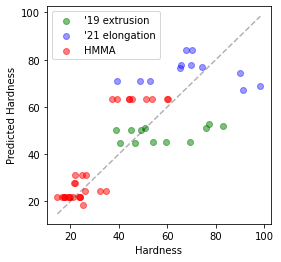

MAPE: 24.4%
RMSE: 14.106


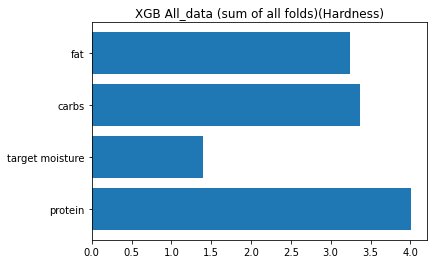

In [19]:
# default parameters
X = data.loc[:, ['protein', 'target moisture', 'carbs' ,'fat' ]]
response = 'Hardness'
y = data.loc[:, response]
print(f'features: {X.columns.values}')

xg_reg = xgb.XGBRegressor()

gkfold = GroupKFold(n_splits=m_groups).split(X, y, list(data.WG_frac))
y_predicted = [0 for i in range(m)]
y_true_groups = [[] for i in range(m_groups)]
y_predicted_groups = [[] for i in range(m_groups)]
y_predicted_2=[]
y_true_2=[]

scores_sum=0

for train_idx, test_idx in gkfold:
    tr_features = X.iloc[train_idx, :]
    tr_label = y.iloc[train_idx]
    test_features = X.iloc[test_idx, :]
    test_label = y.iloc[test_idx]
   # print(test_features)
    xg_reg.fit(tr_features, tr_label)
    
    scores_sum += xg_reg.feature_importances_
   # plt.barh(tr_features.columns, xg_reg.feature_importances_)
   # plt.title('XGB All_data'+ '('+response+')')
   # plt.show()
    
    label_predict = xg_reg.predict(test_features)
   # print(label_predict) 
    m_label_predict = len(label_predict)
    y_predicted[test_idx[0]:test_idx[0] + m_label_predict] = label_predict
    #print(y_predicted) 
    y_predicted_2.extend(label_predict)
    y_true_2.extend(test_label)
    group_idx = groups.index(data.WG_frac[test_idx[0]])
    y_predicted_groups[group_idx] = label_predict
    y_true_groups[group_idx] = y.iloc[test_idx[0]:test_idx[0] + m_label_predict]
    #print('group_idx: ', group_idx)
    
    #print(y_true_groups)
    

y_true_2=np.array(y_true_2)
y_predicted_2=np.array(y_predicted_2)

mape = np.mean(np.abs((y_true_2 - y_predicted_2)/y_true_2))*100
print(f'MAPE: {mape:.1f}%')
rmse = (mean_squared_error(y_true_2, y_predicted_2, squared=False))

print(f'RMSE: {rmse:.3f}')

plt.figure(figsize=(4,4))
ax = plt.axes()
ax.scatter(y[:12], y_predicted[:12], color='green', alpha = 0.5)
ax.scatter(y[12:24], y_predicted[12:24], color='blue', alpha = 0.4)
ax.scatter(y[24:], y_predicted[24:], color='red', alpha=0.5)
plt.legend(["'19 extrusion", "'21 elongation", "HMMA"])
ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', alpha = 0.3)
ax.set_xlabel(response)
ax.set_ylabel('Predicted '+response)
plt.show()

mape = np.mean(np.abs((y - y_predicted)/y))*100
print(f'MAPE: {mape:.1f}%')
rmse = np.sqrt(mean_squared_error(y, y_predicted))
print(f'RMSE: {rmse:.3f}')

plt.barh(tr_features.columns, scores_sum)
plt.title('XGB All_data (sum of all folds)'+ '('+response+')')
plt.show()

features: ['protein' 'carbs' 'fat']
MAPE: 24.5%
RMSE: 14.140


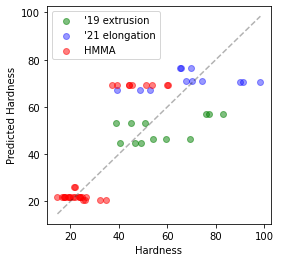

MAPE: 24.5%
RMSE: 14.140


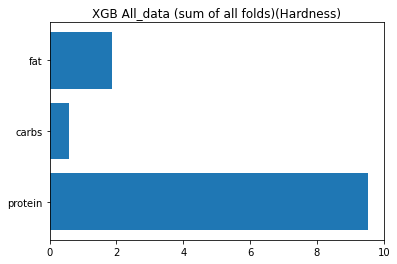

In [20]:
# default parameters
X = data.loc[:, ['protein',  'carbs' ,'fat' ]]
response = 'Hardness'
y = data.loc[:, response]
print(f'features: {X.columns.values}')

xg_reg = xgb.XGBRegressor()

gkfold = GroupKFold(n_splits=m_groups).split(X, y, list(data.WG_frac))
y_predicted = [0 for i in range(m)]
y_true_groups = [[] for i in range(m_groups)]
y_predicted_groups = [[] for i in range(m_groups)]
y_predicted_2=[]
y_true_2=[]

scores_sum=0

for train_idx, test_idx in gkfold:
    tr_features = X.iloc[train_idx, :]
    tr_label = y.iloc[train_idx]
    test_features = X.iloc[test_idx, :]
    test_label = y.iloc[test_idx]
   # print(test_features)
    xg_reg.fit(tr_features, tr_label)
    
    scores_sum += xg_reg.feature_importances_
   # plt.barh(tr_features.columns, xg_reg.feature_importances_)
   # plt.title('XGB All_data'+ '('+response+')')
   # plt.show()
    
    label_predict = xg_reg.predict(test_features)
   # print(label_predict) 
    m_label_predict = len(label_predict)
    y_predicted[test_idx[0]:test_idx[0] + m_label_predict] = label_predict
    #print(y_predicted) 
    y_predicted_2.extend(label_predict)
    y_true_2.extend(test_label)
    group_idx = groups.index(data.WG_frac[test_idx[0]])
    y_predicted_groups[group_idx] = label_predict
    y_true_groups[group_idx] = y.iloc[test_idx[0]:test_idx[0] + m_label_predict]
    #print('group_idx: ', group_idx)
    
    #print(y_true_groups)
    

y_true_2=np.array(y_true_2)
y_predicted_2=np.array(y_predicted_2)

mape = np.mean(np.abs((y_true_2 - y_predicted_2)/y_true_2))*100
print(f'MAPE: {mape:.1f}%')
rmse = (mean_squared_error(y_true_2, y_predicted_2, squared=False))

print(f'RMSE: {rmse:.3f}')

plt.figure(figsize=(4,4))
ax = plt.axes()
ax.scatter(y[:12], y_predicted[:12], color='green', alpha = 0.5)
ax.scatter(y[12:24], y_predicted[12:24], color='blue', alpha = 0.4)
ax.scatter(y[24:], y_predicted[24:], color='red', alpha=0.5)
plt.legend(["'19 extrusion", "'21 elongation", "HMMA"])
ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', alpha = 0.3)
ax.set_xlabel(response)
ax.set_ylabel('Predicted '+response)
plt.show()

mape = np.mean(np.abs((y - y_predicted)/y))*100
print(f'MAPE: {mape:.1f}%')
rmse = np.sqrt(mean_squared_error(y, y_predicted))
print(f'RMSE: {rmse:.3f}')

plt.barh(tr_features.columns, scores_sum)
plt.title('XGB All_data (sum of all folds)'+ '('+response+')')
plt.show()